In [1]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from  xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

In [11]:
# Opening the results 
inner_score, best_params = {}, {}

with open(f'classic_results/best_params', 'rb') as file:
    best_params.update(pickle.load(file))

with open(f'FastKmedoids_results/best_params_large', 'rb') as file:
    best_params.update(pickle.load(file))

with open(f'KFoldFastKmedoids_results/best_params_large', 'rb') as file:
    best_params.update(pickle.load(file))

with open(f'Kmeans_results/best_params_large', 'rb') as file:
    best_params.update(pickle.load(file))

with open(f'MiniBatchKmeans_results/best_params_large', 'rb') as file:
    best_params.update(pickle.load(file))

#############################################################################

with open(f'classic_results/inner_scores', 'rb') as file:
    inner_score.update(pickle.load(file))

with open(f'FastKmedoids_results/inner_scores_large', 'rb') as file:
    inner_score.update(pickle.load(file))

with open(f'KFoldFastKmedoids_results/inner_scores_large', 'rb') as file:
    inner_score.update(pickle.load(file))

with open(f'Kmeans_results/inner_scores_large', 'rb') as file:
    inner_score.update(pickle.load(file))

with open(f'MiniBatchKmeans_results/inner_scores_large', 'rb') as file:
    inner_score.update(pickle.load(file))    

In [12]:
inner_score

{'RF': -173974.7554222493,
 'XGB': -178649.63666242664,
 'FastKmedoids-mahalanobis-sokal-matching': -188761.99051981998,
 'FastKmedoids-mahalanobis-jaccard-matching': -251443.76731603197,
 'FastKmedoids-euclidean-sokal-matching': -191356.71875667333,
 'FastKmedoids-euclidean-jaccard-matching': -204962.6545407861,
 'FastKmedoids-minkowski-sokal-matching': -191217.68702290714,
 'FastKmedoids-minkowski-jaccard-matching': -200109.44156911154,
 'FastKmedoids-canberra-sokal-matching': -177681.6130708362,
 'FastKmedoids-canberra-jaccard-matching': -180552.06230353744,
 'FastKmedoids-RobustMaha-trimmed-sokal-matching': -182114.66861565213,
 'FastKmedoids-RobustMaha-trimmed-jaccard-matching': -179062.2685896134,
 'FastKmedoids-RobustMaha-winsorized-sokal-matching': -192693.09449538472,
 'FastKmedoids-RobustMaha-winsorized-jaccard-matching': -178629.98297197284,
 'FastKmedoids-RobustMaha-MAD-sokal-matching': -187141.95532170893,
 'FastKmedoids-RobustMaha-MAD-jaccard-matching': -179434.6909212450

In [13]:
best_params

{'RF': {'preprocessing__quant__scaler__apply': True,
  'preprocessing__cat__encoder__method': 'ordinal',
  'preprocessing__cat__imputer__apply': True,
  'preprocessing__quant__imputer__apply': True,
  'features_selector__apply': False,
  'preprocessing__quant__scaler__method': 'min-max',
  'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__imputer__n_nearest_features': 7,
  'RF__n_estimators': 74,
  'RF__max_depth': 50,
  'RF__min_samples_split': 7,
  'RF__min_samples_leaf': 2},
 'XGB': {'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'preprocessing__cat__imputer__apply': True,
  'preprocessing__quant__imputer__apply': True,
  'features_selector__apply': False,
  'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'knn',
  'preprocessing__cat__imputer__n_neighbors': 4,
  'preprocessing__

In [14]:
inner_score_values = - np.array(list(inner_score.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

In [22]:
other_clustering_methods = ['Kmeans', 'MBKmeans']
classic_approach = ['RF', 'XGB']
our_clustering_methods = [x for x in inner_score.keys() if x not in other_clustering_methods + classic_approach]

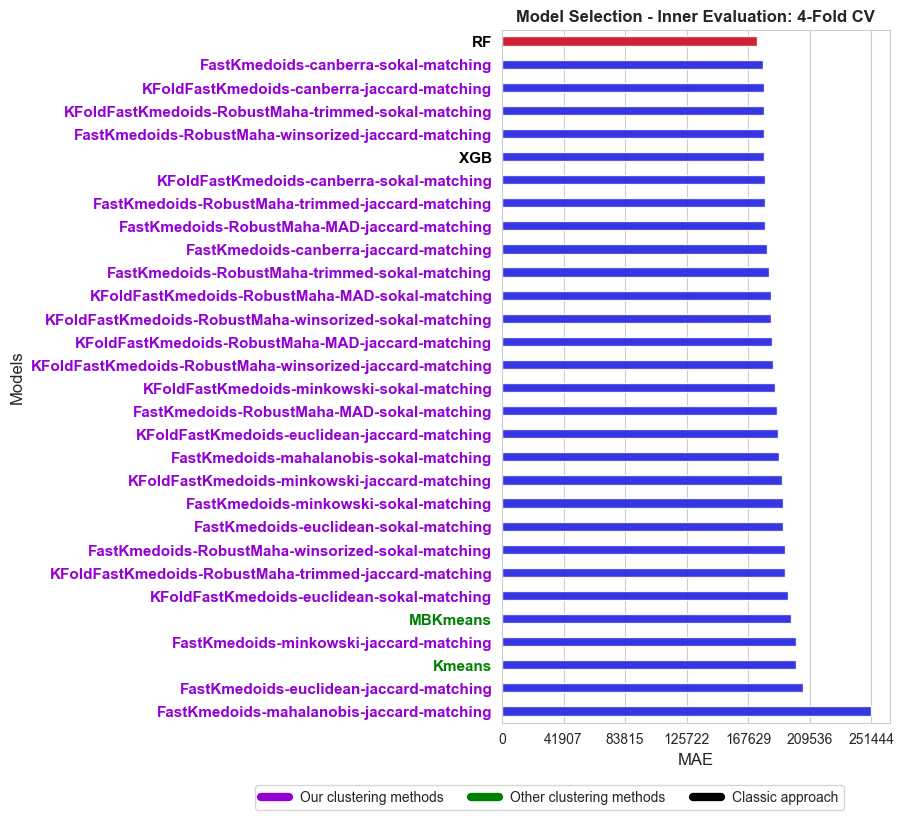

The best model among all the 30 alternatives plotted, according to the inner evaluation, is: RF
MAE of the best model: 173974.755

The best model hyper-parameters are: {'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__imputer__n_nearest_features': 7, 'RF__n_estimators': 74, 'RF__max_depth': 50, 'RF__min_samples_split': 7, 'RF__min_samples_leaf': 2}


In [46]:
fig, axes = plt.subplots(figsize=(5,9))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=12, weight='bold')

for label in axes.get_yticklabels():
    if label.get_text() in our_clustering_methods:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in other_clustering_methods:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in classic_approach:
        label.set_weight('bold')
        label.set_color('black') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Our clustering methods'),
    plt.Line2D([0], [0], color='green', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='black', lw=6, label='Classic approach'),
]

# Add legend to the figure
axes.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.9, -0.08), ncol=len(legend_elements), fontsize=10)

file_name = r'C:\Users\fscielzo\Documents\DataScience-GitHub\TFM\Clustering\plots\supervised_clustering_comparison'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params[best_pipeline])

In [23]:
inner_score['RF']

-173974.7554222493

In [24]:
inner_score['FastKmedoids-RobustMaha-n_clusters=2']

-175537.06751740354

In [22]:
best_params['FastKmedoids-RobustMaha-n_clusters=2']

{'preprocessing__quant__imputer__method': 'simple_median',
 'preprocessing__cat__imputer__method': 'simple_most_frequent',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__encoder__method': 'ordinal',
 'features_selector__apply': False,
 'clustering_model__n_clusters': 2,
 'clustering_model__method': 'pam',
 'clustering_model__init': 'heuristic',
 'clustering_model__frac_sample_size': 0.03,
 'clustering_model__d1': 'robust_mahalanobis',
 'clustering_model__d2': 'jaccard',
 'clustering_model__robust_maha_method': 'winsorized',
 'clustering_model__alpha': 0.4,
 'clustering_model__estimators__0__n_estimators': 115,
 'clustering_model__estimators__0__max_depth': 40,
 'clustering_model__estimators__0__min_samples_split': 4,
 'clustering_model__estimators__0__min_samples_leaf': 2,
 'clustering_model__estimators__1__max_depth': 7,
 'clustering_model__estimators__1__lambda': 0.30000000000000004,
 'clustering_model__estimators__1__n_estimators': 50,
 'clustering_model__estim